<a href="https://colab.research.google.com/github/149189/Experiments_on_Food101_dataset/blob/main/Model_3_on_Food_101_data_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import zipfile
from pathlib import Path

In [2]:
def unzip_data(zip_path, extract_to="."):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

# Define paths
train_dir = Path("101_food_classes_10_percent/train")
test_dir = Path("101_food_classes_10_percent/test")

--2024-08-20 08:11:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   107MB/s    in 19s     

2024-08-20 08:11:41 (82.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
], name="data_augmentation")

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [8]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)
model = models.Model(inputs, outputs)

In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    metrics=["accuracy"]
)

In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/fine_tuning")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("fine_tuned_model.keras", save_best_only=True)

In [11]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 222ms/step - accuracy: 0.0422 - loss: 4.5065 - val_accuracy: 0.2268 - val_loss: 3.7513
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 70s 197ms/step - accuracy: 0.2312 - loss: 3.6645 - val_accuracy: 0.3522 - val_loss: 2.8611
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - accuracy: 0.3386 - loss: 3.0639 - val_accuracy: 0.4294 - val_loss: 2.3734
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 186ms/step - accuracy: 0.3988 - loss: 2.7098 - val_accuracy: 0.4754 - val_loss: 2.1295
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.4345 - loss: 2.4721 - val_accuracy: 0.4412 - val_loss: 2.1377


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [12]:

results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.4874 - loss: 2.0333


[2.0241615772247314, 0.4883960485458374]

In [13]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-20 08:22:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-08-20 08:22:19 (18.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [14]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

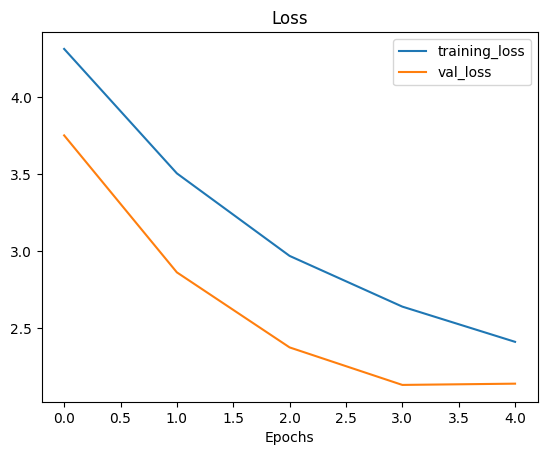

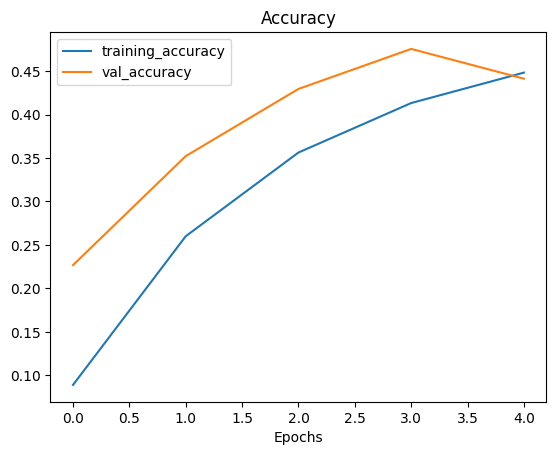

In [15]:
plot_loss_curves(history)